## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
taxi_data = pd.read_csv("/content/drive/MyDrive/lectures/Проектная практика/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

## 2. Знакомство с данными, базовый анализ и расширение данных

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [ ]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
taxi_data['pickup_datetime'].max()

Timestamp('2016-06-30 23:59:39')

In [ ]:
taxi_data['pickup_datetime'].min()

Timestamp('2016-01-01 00:00:17')

### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [ ]:
taxi_data.isnull().sum().sum()

0

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [ ]:
taxi_data.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [ ]:
taxi_data.passenger_count.max()

9

In [ ]:
taxi_data.trip_duration.describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [ ]:
(taxi_data['dropoff_datetime'] - taxi_data['pickup_datetime']).dt.total_seconds().median()

662.0

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4 **add_datetime_features()**
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [ ]:
def add_datetime_features(df):
    # добавление новых столбцов
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()

    return df

In [ ]:
taxi_data = add_datetime_features(taxi_data)

In [ ]:
len(taxi_data.loc[taxi_data['pickup_day_of_week'] == 'Saturday'])

220868

In [ ]:
taxi_data['pickup_date'].value_counts().mean()

8014.527472527472

### Задание 2.5 **add_holiday_features()**
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [ ]:
holiday_data = pd.read_csv('/content/drive/MyDrive/lectures/Проектная практика/holiday_data.csv', sep=';')

In [ ]:
def add_holiday_features(df_train, df_holiday):
    # Преобразуем столбец 'date' в datetime и извлеките дату
    df_holiday['date'] = pd.to_datetime(df_holiday['date']).dt.date

    # Объединим DataFrame'ы по столбцу 'pickup_date' с использованием left join
    new_df = pd.merge(df_train, df_holiday[['date', 'holiday']], left_on='pickup_date', right_on='date', how='left')

    # Заменим пропущенные значения в столбце 'holiday' на 0
    new_df['pickup_holiday'] = new_df['holiday'].fillna(0)

    # Преобразуем значения столбца 'pickup_holiday' в бинарный формат (0 или 1)
    new_df['pickup_holiday'] = new_df['pickup_holiday'].apply(lambda x: 0 if x == 0 else 1)

    # Удалим лишние столбцы
    new_df = new_df.drop(columns=['holiday', 'date'], axis=1)

    return new_df

In [ ]:
taxi_data = add_holiday_features(taxi_data, holiday_data)

In [ ]:
taxi_data[taxi_data['pickup_holiday'] != 0].trip_duration.median()

585.0

### Задание 2.6 **add_osrm_features()**
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [ ]:
osrm_data = pd.read_csv('/content/drive/MyDrive/lectures/Проектная практика/osrm_data_train.csv')


In [ ]:
def add_osrm_features(df1, df2):
  df2_subset = df2[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
  new_df = pd.merge(df1, df2_subset, on='id', how='left')

  return new_df

In [ ]:
taxi_data = add_osrm_features(taxi_data, osrm_data)

In [ ]:
taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()

372.5

In [ ]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [ ]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7. **add_geographical_features()**
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [ ]:
def add_geographical_features(df):
  df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'],
                                                    df['pickup_longitude'],
                                                    df['dropoff_latitude'],
                                                    df['dropoff_longitude'])
  df['direction'] = get_angle_direction(df['pickup_latitude'],
                                        df['pickup_longitude'],
                                        df['dropoff_latitude'],
                                        df['dropoff_longitude'])
  return df

In [ ]:
taxi_data = add_geographical_features(taxi_data)

In [ ]:
taxi_data['haversine_distance'].median()

2.0937171329263693

### Задание 2.8. **add_cluster_features()**
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [ ]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

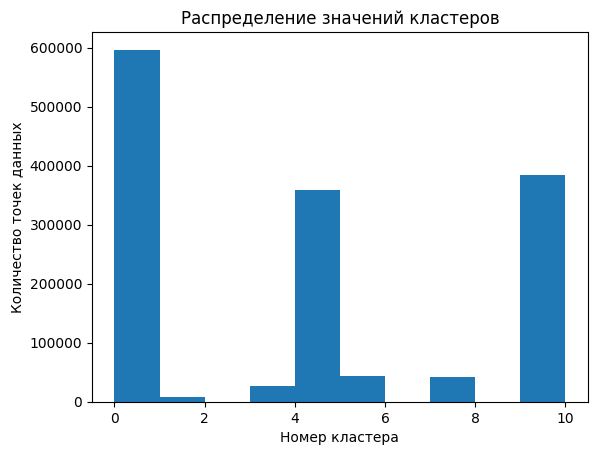

In [ ]:
plt.hist(kmeans.labels_, bins=range(11))  # Предполагая, что у вас 10 кластеров (0-9)
plt.xlabel('Номер кластера')
plt.ylabel('Количество точек данных')
plt.title('Распределение значений кластеров')
plt.show()

In [ ]:
def add_cluster_features(df, kmeans):
  # создаем обучающую выборку из географических координат всех точек
  df_coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                      df[['dropoff_latitude', 'dropoff_longitude']]))
  df['geo_cluster'] = kmeans.predict(df_coords)

  return df

In [ ]:
taxi_data = add_cluster_features(taxi_data, kmeans)

In [ ]:
taxi_data['geo_cluster'].value_counts().min()

2

### Задание 2.9. **add_weather_features()**
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/lectures/Проектная практика/weather_data.csv')

In [ ]:
def add_weather_features(df_train, df_weather_features):
  df_weather_features_subset = df_weather_features[['time',
                                                    'temperature',
                                                    'visibility',
                                                    'wind speed',
                                                    'precip',
                                                    'events']].copy()

  df_weather_features_subset['time'] = pd.to_datetime(df_weather_features_subset['time'])
  df_weather_features_subset['date'] = df_weather_features_subset['time'].dt.date
  df_weather_features_subset['hour'] = df_weather_features_subset['time'].dt.hour

  df_train = pd.merge(df_train,
                      df_weather_features_subset,
                      left_on=['pickup_date', 'pickup_hour'],
                      right_on=['date', 'hour'], how='left')

  df_train = df_train.drop(columns=['date', 'hour', 'time'], axis=1)

  # df_train['events'] = df_train['events'].fillna(0)

  return df_train

In [ ]:
taxi_data = add_weather_features(taxi_data, weather_data)

In [ ]:
sum_event_snow = (taxi_data.loc[:, 'events'].values == 'Snow').sum()

In [ ]:
sum_event_snow

13126

In [ ]:
total_observations = len(taxi_data)
observations_with_missing_weather = len(taxi_data[taxi_data['events'].isnull()])
missing_weather_percentage = (observations_with_missing_weather / total_observations) * 100

In [ ]:
missing_weather_percentage

0.8248757064780714

### Задание 2.10. **fill_null_weather_data()**
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [ ]:
def fill_null_weather_data(data):
  columns_to_loop_weather = ['temperature', 'visibility', 'wind speed', 'precip']
  for column in columns_to_loop_weather:
    data[column] = data[column].fillna(
        data.groupby('pickup_date')[column].transform('median')
    )

  columns_to_loop_osrm = ['total_distance', 'total_travel_time', 'number_of_steps']
  for column in columns_to_loop_osrm:
    data[column] = data[column].fillna(data[column].median())

  data['events'] = data['events'].fillna('None')

  return data

In [ ]:
taxi_data = fill_null_weather_data(taxi_data)

In [ ]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        0
total_travel_time     0
number_of_steps       0
haversine_distance    0
direction             0
geo_cluster           0
temperature           0
visibility            0
wind speed            0
precip                0
events                0
dtype: int64

In [ ]:
taxi_data['temperature'].median()

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


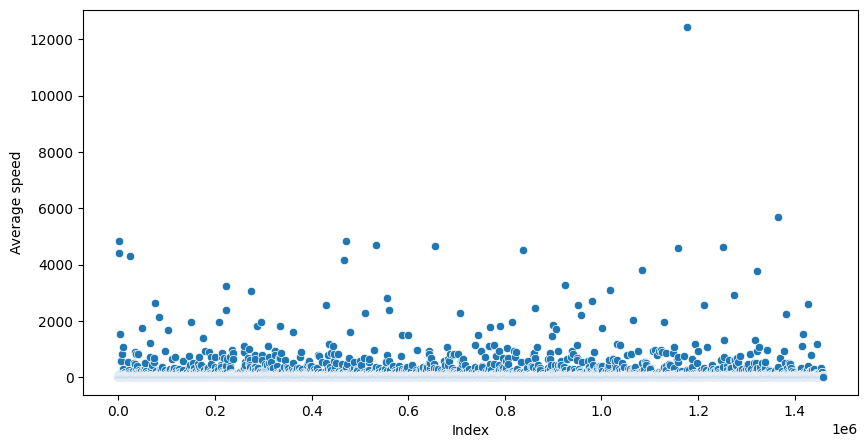

In [ ]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [ ]:
NUMBER_OF_SECONDS_IN_DAY = 86400
taxi_data.loc[taxi_data['trip_duration'] > NUMBER_OF_SECONDS_IN_DAY].shape[0]

4

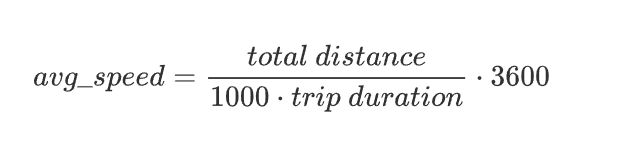

In [ ]:
taxi_data.loc[(taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6) > 300].shape[0]

407

In [ ]:
taxi_data.shape[0]

1458644

In [ ]:
taxi_data = taxi_data.loc[~(taxi_data['trip_duration'] > NUMBER_OF_SECONDS_IN_DAY)]
taxi_data = taxi_data.loc[~((taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6) > 300)]

In [ ]:
taxi_data.shape[0]

1458233

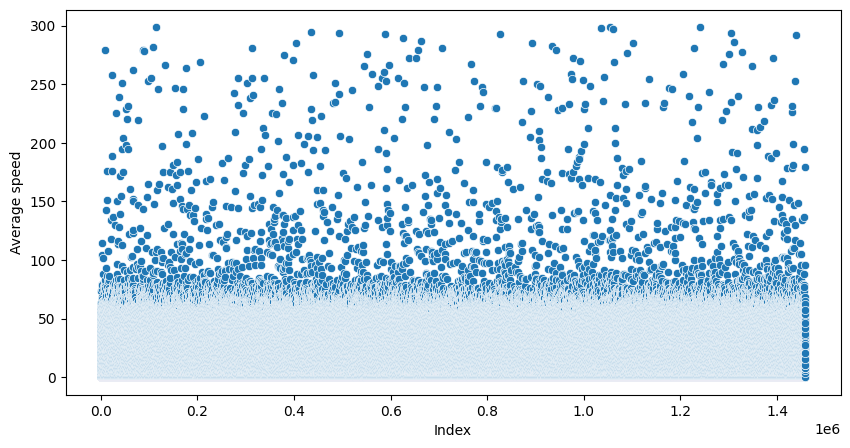

In [ ]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [ ]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

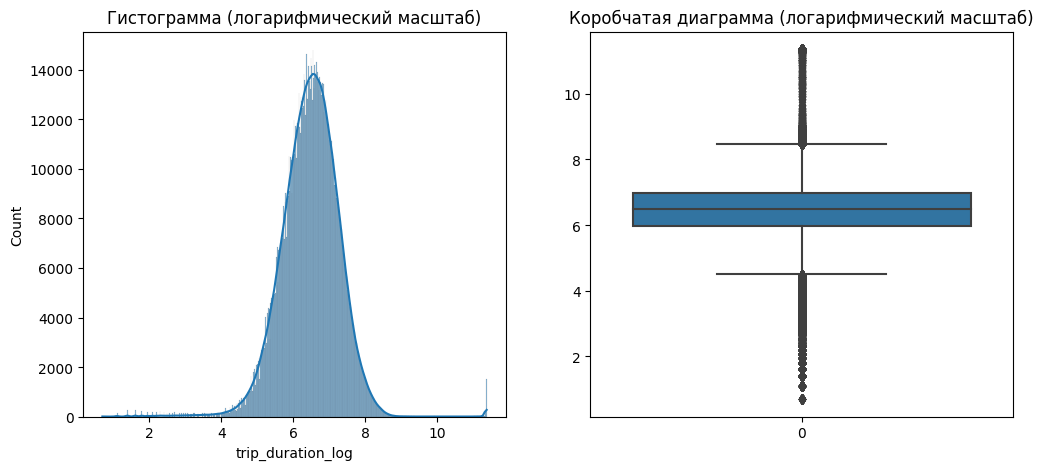

In [ ]:
# Построим объекты для графиков
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Один ряд, два столбца

# Гистограмма в логарифмическом масштабе
sns.histplot(taxi_data['trip_duration_log'], ax=axes[0], kde=True)  # Первая ячейка
axes[0].set_title("Гистограмма (логарифмический масштаб)")

# Коробчатая диаграмма (ящик с усами) в логарифмическом масштабе
sns.boxplot(taxi_data['trip_duration_log'], ax=axes[1])  # Вторая ячейка
axes[1].set_title("Коробчатая диаграмма (логарифмический масштаб)")

# Показать графики
plt.show()

In [ ]:
# Проверка на нормальность с помощью теста Д’Агостино-Пирсона
statistic, p_value = stats.normaltest(taxi_data['trip_duration_log'])
alpha = 0.05

if p_value < alpha:
    print("Распределение НЕ является нормальным (p-value =", p_value, ")")
else:
    print("Распределение является нормальным (p-value =", p_value, ")")

Распределение НЕ является нормальным (p-value = 0.0 )


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

In [ ]:
max_color_vendor = taxi_data['vendor_id'].nunique()
custom_palette = sns.color_palette("Set1", max_color_vendor)

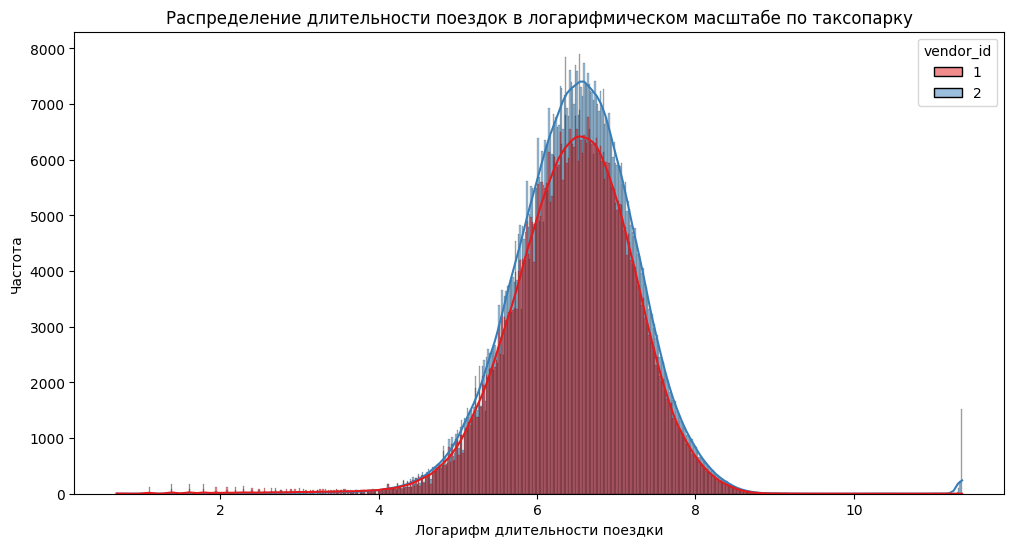

In [ ]:
# Создаем палитру цветов
plt.figure(figsize=(12, 6))

# Гистограмма в логарифмическом масштабе
sns.histplot(data = taxi_data,
             x = 'trip_duration_log',
             hue = 'vendor_id',
             kde=True,
             common_norm=False,
             palette=custom_palette)  # Первая ячейка
plt.title('Распределение длительности поездок в логарифмическом масштабе по таксопарку')
plt.xlabel('Логарифм длительности поездки')
plt.ylabel('Частота')
plt.show()

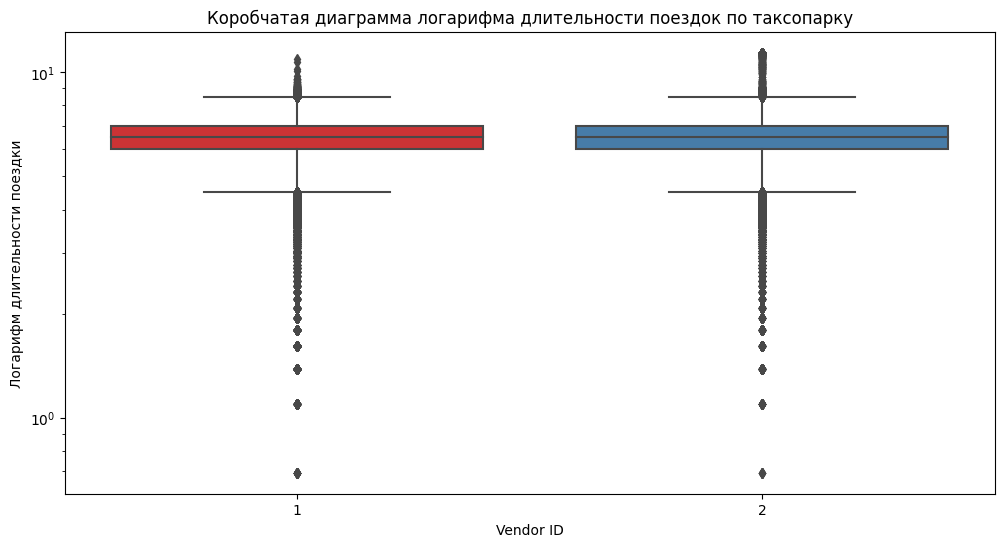

In [ ]:
# Коробчатая диаграмма (ящик с усами) в логарифмическом масштабе
plt.figure(figsize=(12, 6))
sns.boxplot(data = taxi_data,
            x='vendor_id',
            y='trip_duration_log',
            palette=custom_palette)  # Вторая ячейка
plt.title('Коробчатая диаграмма логарифма длительности поездок по таксопарку')
plt.xlabel('Vendor ID')
plt.ylabel('Логарифм длительности поездки')
plt.yscale('log')  # Установите логарифмическую шкалу на оси y
plt.show()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

In [ ]:
max_color_vendor = taxi_data['store_and_fwd_flag'].nunique()
custom_palette = sns.color_palette("Set1", max_color_vendor)

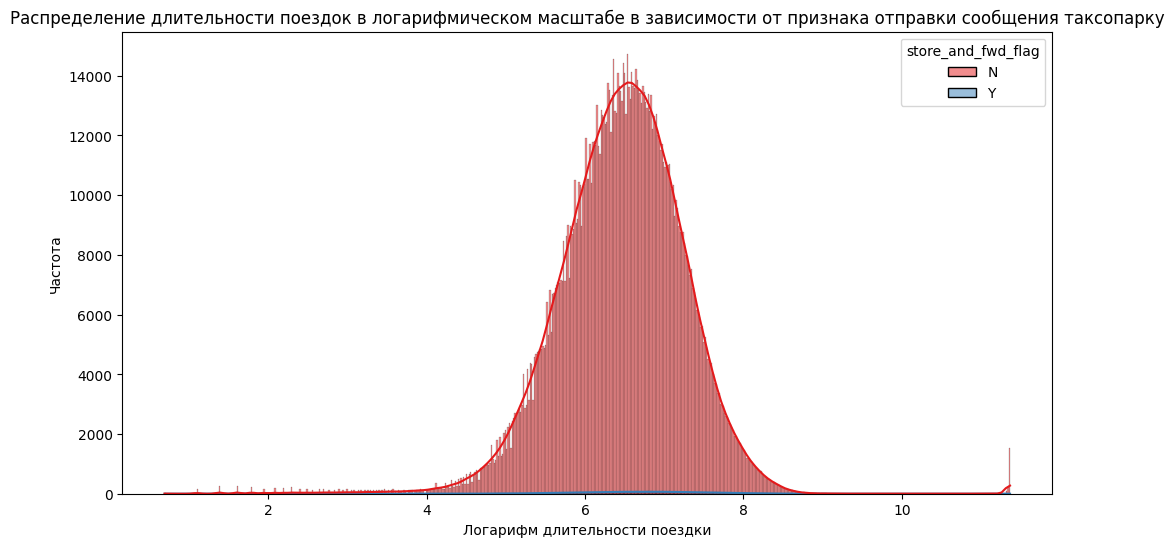

In [ ]:
# Создаем палитру цветов
plt.figure(figsize=(12, 6))

# Гистограмма в логарифмическом масштабе
sns.histplot(data = taxi_data,
             x = 'trip_duration_log',
             hue = 'store_and_fwd_flag',
             kde=True,
             common_norm=False,
             palette=custom_palette)  # Первая ячейка
plt.title('Распределение длительности поездок в логарифмическом масштабе в зависимости от признака отправки сообщения таксопарку')
plt.xlabel('Логарифм длительности поездки')
plt.ylabel('Частота')
plt.show()

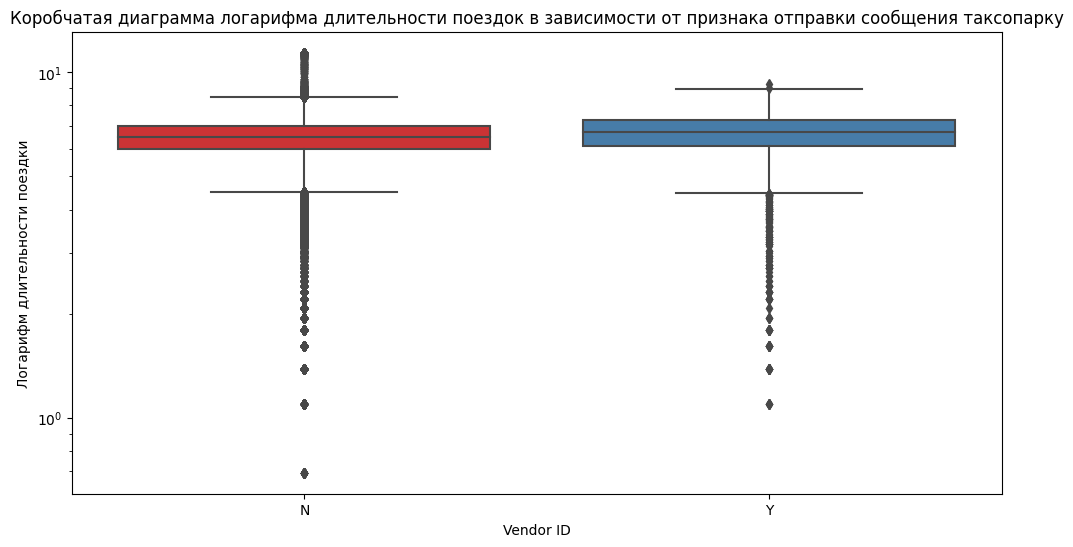

In [ ]:
# Коробчатая диаграмма (ящик с усами) в логарифмическом масштабе
plt.figure(figsize=(12, 6))
sns.boxplot(data = taxi_data,
            x='store_and_fwd_flag',
            y='trip_duration_log',
            palette=custom_palette)  # Вторая ячейка
plt.title('Коробчатая диаграмма логарифма длительности поездок в зависимости от признака отправки сообщения таксопарку')
plt.xlabel('Vendor ID')
plt.ylabel('Логарифм длительности поездки')
plt.yscale('log')  # Установите логарифмическую шкалу на оси y
plt.show()

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

In [ ]:
trip_count_by_hour = taxi_data.groupby('pickup_hour')['id'].count()

In [ ]:
pickup_hour = trip_count_by_hour.index.tolist()

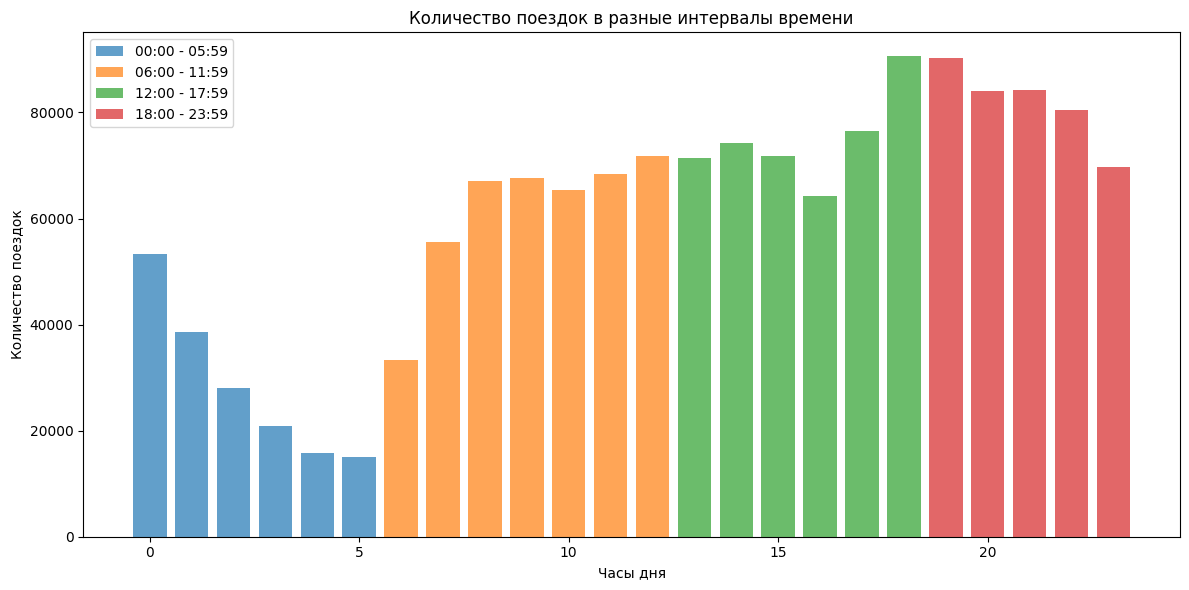

In [ ]:
# Данные
pickup_hour = trip_count_by_hour.index.tolist()
count = trip_count_by_hour.values.tolist()

# Создаем фигуру и подграфики
fig, ax = plt.subplots(figsize=(12, 6))

# Рисуем столбцы для каждого интервала времени
ax.bar(pickup_hour[:6], count[:6], label='00:00 - 05:59', alpha=0.7)
ax.bar(pickup_hour[6:13], count[6:13], label='06:00 - 11:59', alpha=0.7)
ax.bar(pickup_hour[13:19], count[13:19], label='12:00 - 17:59', alpha=0.7)
ax.bar(pickup_hour[19:], count[19:], label='18:00 - 23:59', alpha=0.7)

# Настройка внешнего вида графика
ax.set_xlabel('Часы дня')
ax.set_ylabel('Количество поездок')
ax.set_title('Количество поездок в разные интервалы времени')
ax.legend()

# Отображаем график
plt.tight_layout()
plt.show()

In [ ]:
peak_median_duration_time = taxi_data.groupby('pickup_hour')['trip_duration'].median()

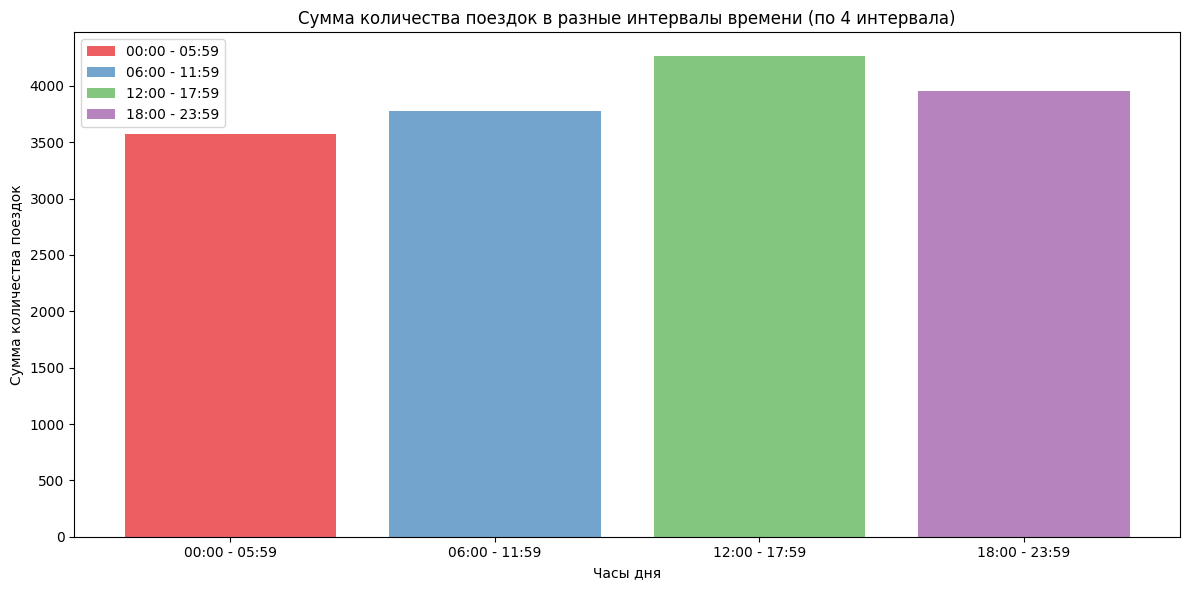

In [ ]:
# Данные
pickup_hour = peak_median_duration_time.index.tolist()
count = peak_median_duration_time.values.tolist()
sum_count = [sum(count[i:i+6]) for i in range(0, len(count), 6)]
between_time_label = ['00:00 - 05:59', '06:00 - 11:59', '12:00 - 17:59', '18:00 - 23:59']
custom_palette = sns.color_palette("Set1", 4)

# Создаем фигуру и подграфики
fig, ax = plt.subplots(figsize=(12, 6))

# Рисуем столбцы с суммой значений для каждого интервала времени
ax.bar(between_time_label, sum_count, label=between_time_label, alpha=0.7, color=custom_palette)

# Настройка внешнего вида графика
ax.set_xlabel('Часы дня')
ax.set_ylabel('Сумма количества поездок')
ax.set_title('Сумма количества поездок в разные интервалы времени (по 4 интервала)')
ax.legend()

# Отображаем график
plt.tight_layout()
plt.show()

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


In [ ]:
def sorted_day_of_week(df):
  # Сортируем в соотвествии с последовательностью дней в неделе
  day_of_week_order = {
      'Monday': 0,
      'Tuesday': 1,
      'Wednesday': 2,
      'Thursday': 3,
      'Friday': 4,
      'Saturday': 5,
      'Sunday': 6
      }

  day_of_week_sorted = df.loc[
    sorted(day_of_week_order, key=lambda x: day_of_week_order[x])
    ]

  return day_of_week_sorted

In [ ]:
trip_count_by_day_of_week = taxi_data.groupby('pickup_day_of_week')['id'].count()

In [ ]:
trip_count_by_day_of_week_sorted = sorted_day_of_week(trip_count_by_day_of_week)

In [ ]:
trip_count_by_day_of_week_sorted

pickup_day_of_week
Monday       187357
Tuesday      202696
Wednesday    210094
Thursday     218497
Friday       223484
Saturday     220805
Sunday       195300
Name: id, dtype: int64

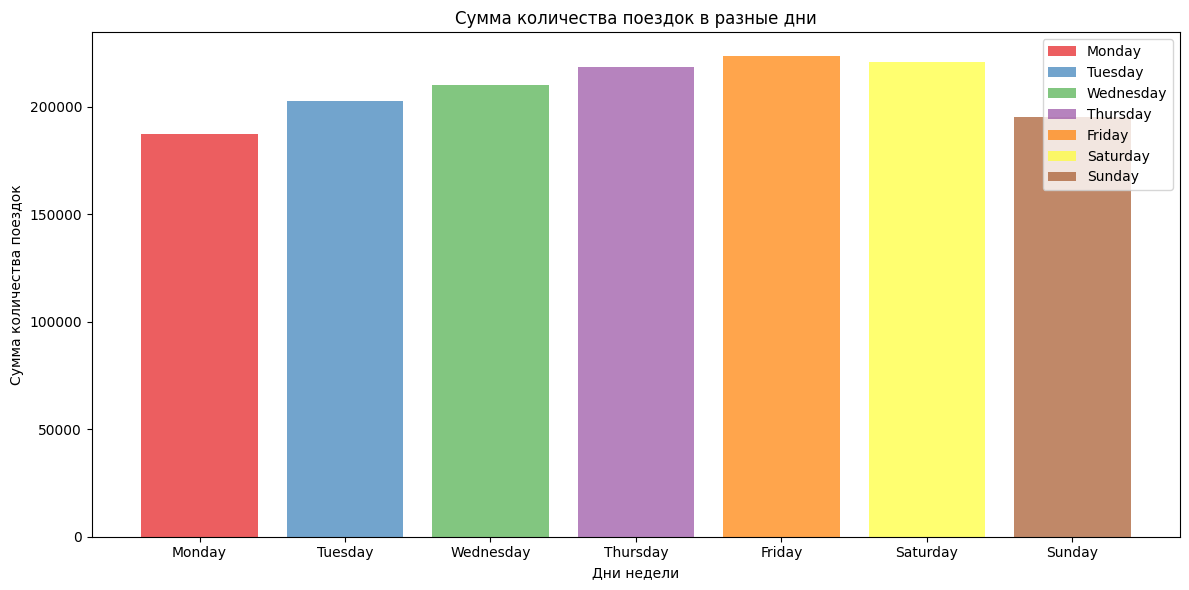

In [ ]:
# Данные
days_of_week = trip_count_by_day_of_week_sorted.index.tolist()
count = trip_count_by_day_of_week_sorted.values.tolist()

custom_palette = sns.color_palette("Set1", len(days_of_week))

# Создаем фигуру и подграфики
fig, ax = plt.subplots(figsize=(12, 6))

# Рисуем столбцы с суммой значений для каждого интервала времени
ax.bar(days_of_week, count, label=days_of_week, alpha=0.7, color=custom_palette)

# Настройка внешнего вида графика
ax.set_xlabel('Дни недели')
ax.set_ylabel('Сумма количества поездок')
ax.set_title('Сумма количества поездок в разные дни')
ax.legend()

# Отображаем график
plt.tight_layout()
plt.show()

In [ ]:
trip_median_by_day_of_week = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()

In [ ]:
trip_median_by_day_of_week_sorted = sorted_day_of_week(trip_median_by_day_of_week)

In [ ]:
trip_median_by_day_of_week_sorted

pickup_day_of_week
Monday       630.0
Tuesday      679.0
Wednesday    694.0
Thursday     710.0
Friday       686.0
Saturday     637.0
Sunday       602.0
Name: trip_duration, dtype: float64

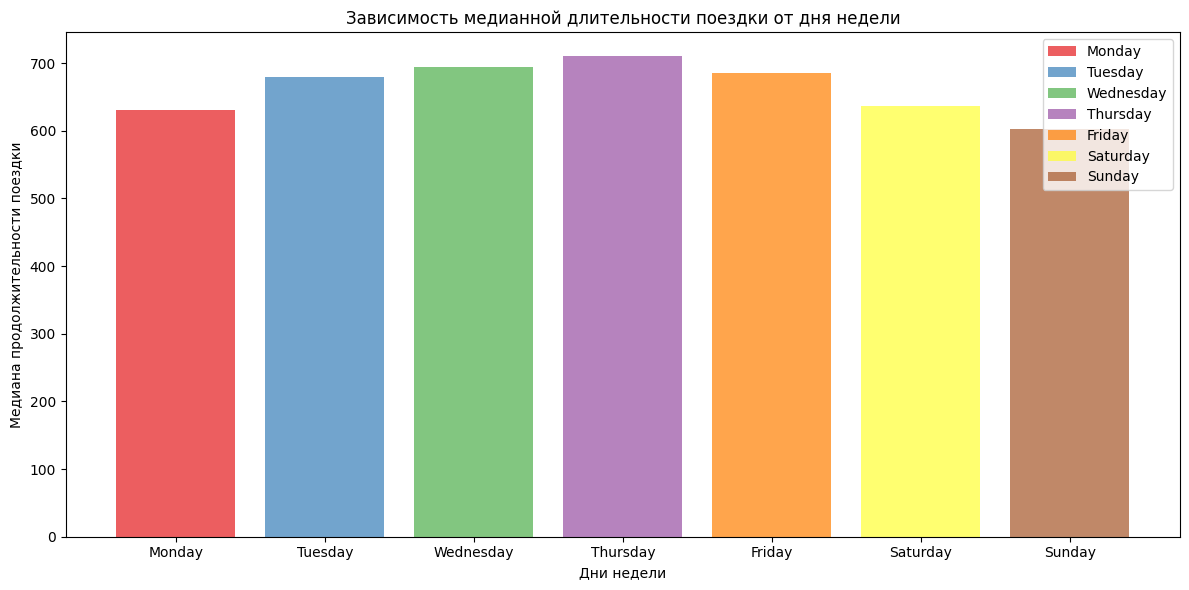

In [ ]:
# Данные
days_of_week = trip_median_by_day_of_week_sorted.index.tolist()
count = trip_median_by_day_of_week_sorted.values.tolist()

custom_palette = sns.color_palette("Set1", len(days_of_week))

# Создаем фигуру и подграфики
fig, ax = plt.subplots(figsize=(12, 6))

# Рисуем столбцы с суммой значений для каждого интервала времени
ax.bar(days_of_week, count, label=days_of_week, alpha=0.7, color=custom_palette)

# Настройка внешнего вида графика
ax.set_xlabel('Дни недели')
ax.set_ylabel('Медиана продолжительности поездки')
ax.set_title('Зависимость медианной длительности поездки от дня недели')
ax.legend()

# Отображаем график
plt.tight_layout()
plt.show()

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [ ]:
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [ ]:
taxi_data_for_pivot = taxi_data.copy()

In [ ]:
# Преобразовываем столбец 'pickup_day_of_week' в категорию с заданным порядком
taxi_data_for_pivot['pickup_day_of_week'] = pd.Categorical(taxi_data_for_pivot['pickup_day_of_week'],
                                                           categories=day_of_week,
                                                           ordered=True)

In [ ]:
# Сортируем DataFrame по новому порядку
taxi_data_for_pivot = taxi_data_for_pivot.sort_values('pickup_day_of_week')

In [ ]:
pivot_table = pd.pivot_table(taxi_data_for_pivot, values='trip_duration', index='pickup_hour', columns='pickup_day_of_week', aggfunc=np.median)

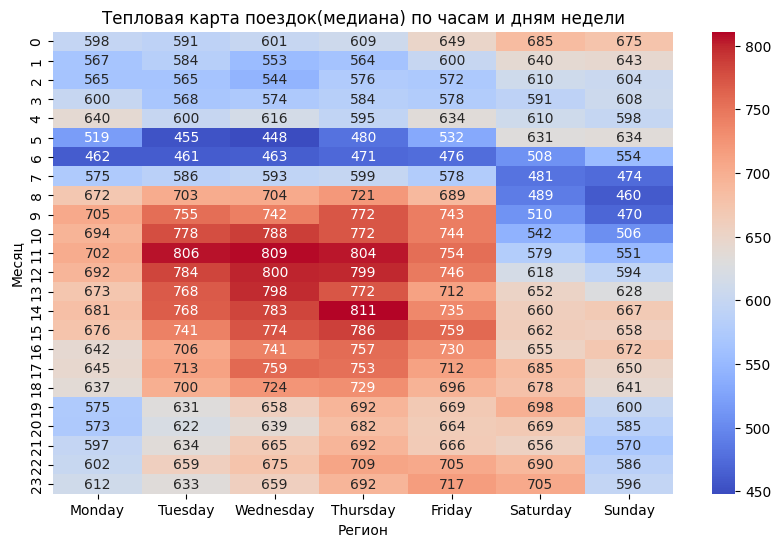

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='coolwarm')
plt.title('Тепловая карта поездок(медиана) по часам и дням недели')
plt.xlabel('Регион')
plt.ylabel('Месяц')
plt.show()

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

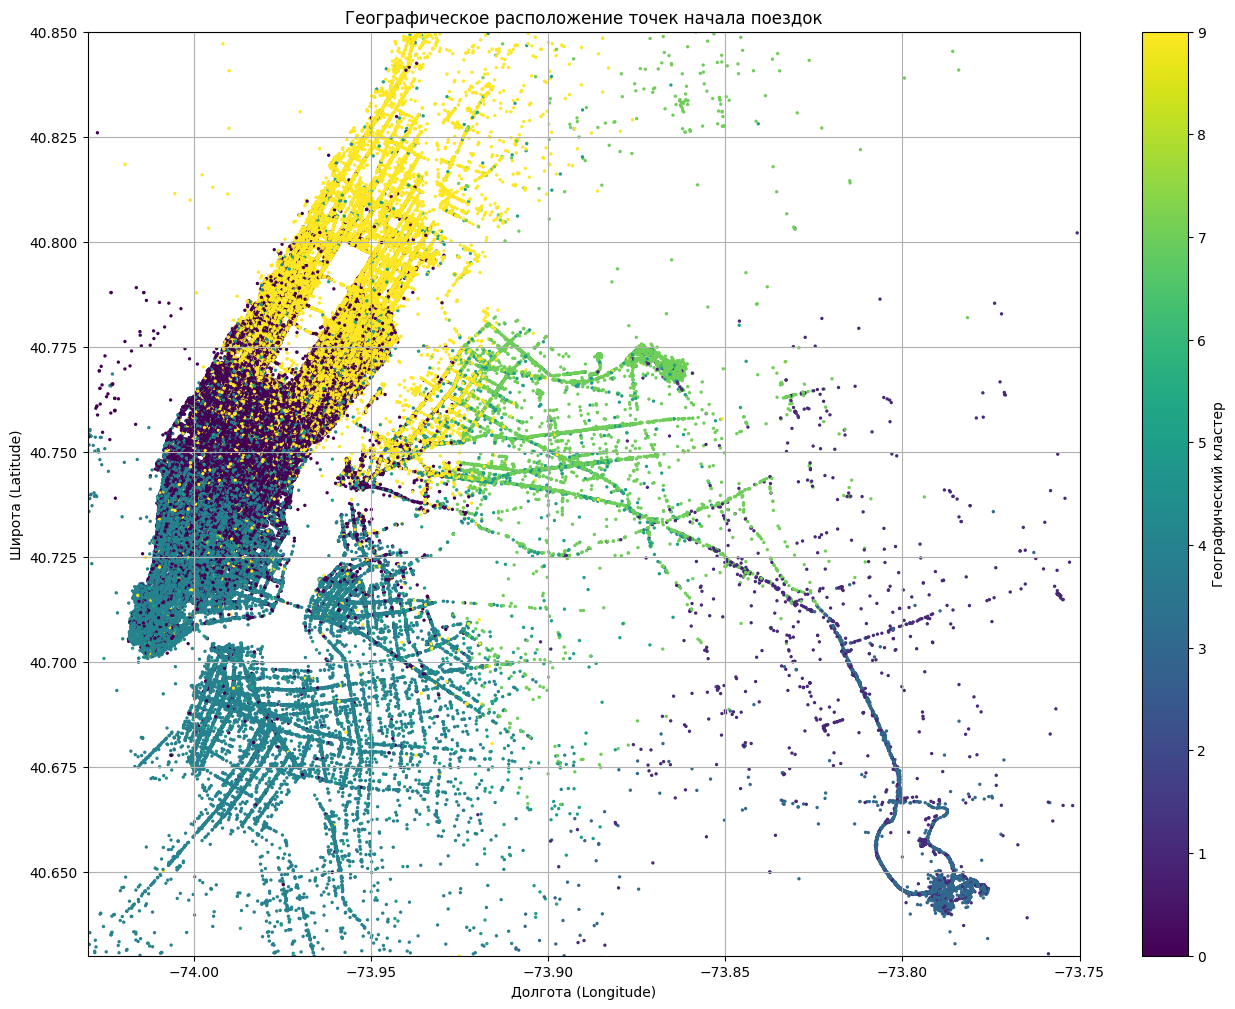

In [ ]:
# Создаем скатерограмму
plt.figure(figsize=(16, 12))
plt.scatter(x = taxi_data['pickup_longitude'], y = taxi_data['pickup_latitude'], c=taxi_data['geo_cluster'], marker='o', s=2)

# Настройка внешнего вида графика
plt.colorbar(label='Географический кластер')
plt.title('Географическое расположение точек начала поездок')
plt.xlabel('Долгота (Longitude)')
plt.ylabel('Широта (Latitude)')

plt.xlim(city_long_border)
plt.ylim(city_lat_border)

# Отображаем график
plt.grid(True)
plt.show()

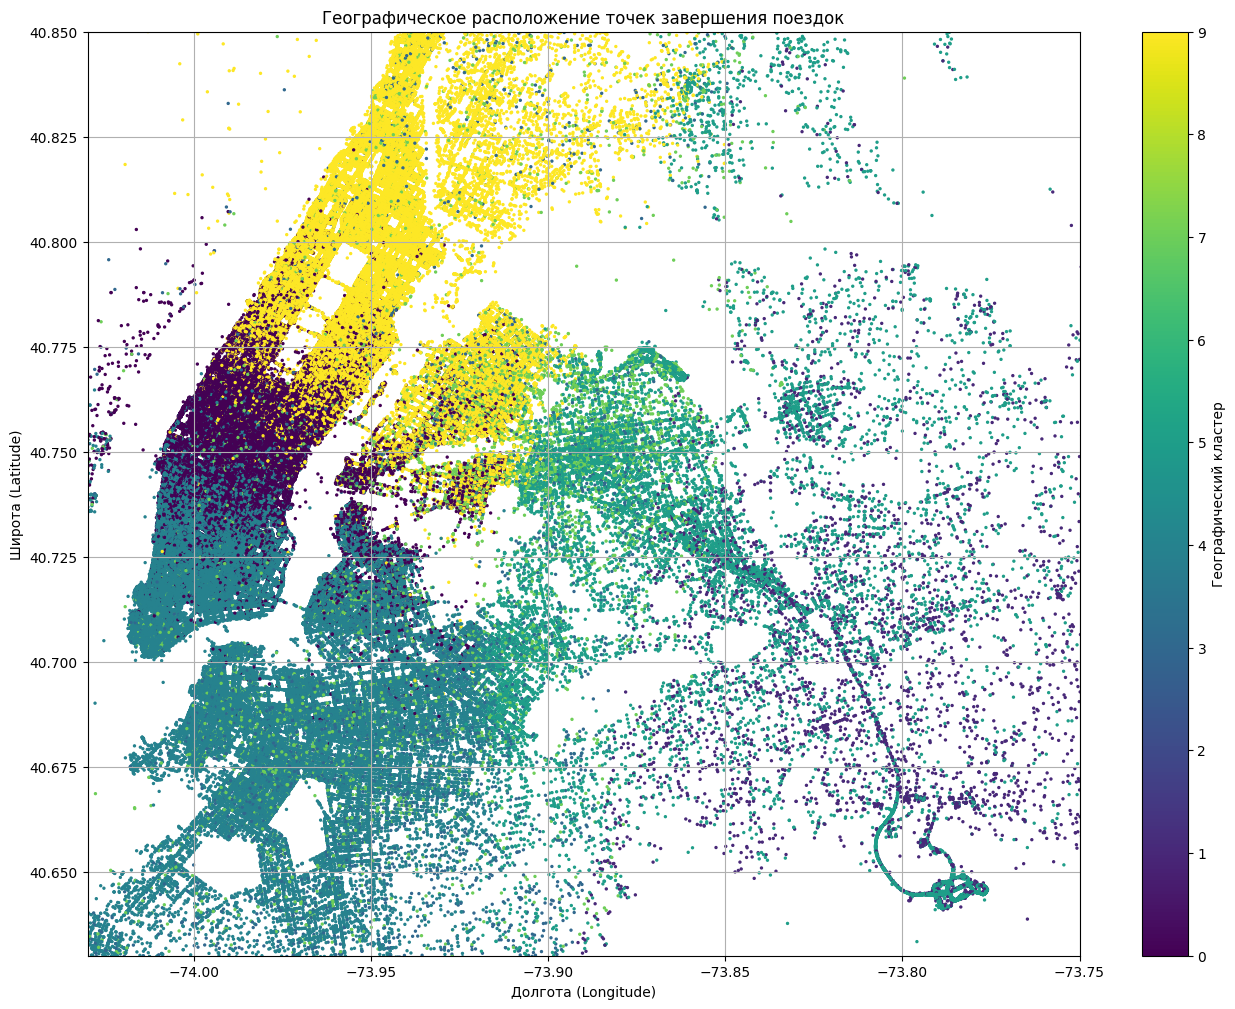

In [ ]:
# Создаем скатерограмму
plt.figure(figsize=(16, 12))
plt.scatter(x = taxi_data['dropoff_longitude'], y = taxi_data['dropoff_latitude'], c=taxi_data['geo_cluster'], marker='o', s=2)

# Настройка внешнего вида графика
plt.colorbar(label='Географический кластер')
plt.title('Географическое расположение точек завершения поездок')
plt.xlabel('Долгота (Longitude)')
plt.ylabel('Широта (Latitude)')

plt.xlim(city_long_border)
plt.ylim(city_lat_border)

# Отображаем график
plt.grid(True)
plt.show()

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [ ]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [ ]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [ ]:
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [ ]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [ ]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

In [ ]:
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

In [ ]:
round(train_data['vendor_id'].mean(), 2)

0.53

In [ ]:
round(train_data['store_and_fwd_flag'].mean(), 3)

0.006

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [ ]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

In [ ]:
one_hot_encoder = preprocessing.OneHotEncoder(drop='first')

In [ ]:
test_data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out()
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)
test_data_onehot.shape[1]

18

Добавим полученную таблицу с закодированными признаками:

In [ ]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
    )
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [ ]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [ ]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [ ]:
k_best = feature_selection.SelectKBest(score_func=feature_selection.f_regression,
                                       k=25)

In [ ]:
X_train_selected = k_best.fit_transform(X_train, y_train_log)
X_valid_selected = k_best.transform(X_valid)

In [ ]:
# Получаем индексы выбранных признаков
selected_indices = k_best.get_support(indices=True)

# Получаем список отобранных признаков
best_features = X_train.columns[selected_indices]

In [ ]:
best_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'temperature',
       'pickup_day_of_week_Monday', 'pickup_day_of_week_Saturday',
       'pickup_day_of_week_Sunday', 'pickup_day_of_week_Thursday',
       'pickup_day_of_week_Tuesday', 'pickup_day_of_week_Wednesday',
       'geo_cluster_1', 'geo_cluster_3', 'geo_cluster_5', 'geo_cluster_7',
       'geo_cluster_9'],
      dtype='object')

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [ ]:
#scaler = preprocessing.MinMaxScaler()
#X_train_scaler = scaler.fit_transform(X_train.iloc[:, selected_indices])
#X_valid_scaler = scaler.fit_transform(X_valid.iloc[:, selected_indices])

In [ ]:
scaler = preprocessing.MinMaxScaler()
X_train_scaler = scaler.fit_transform(X_train[best_features])
X_valid_scaler = scaler.transform(X_valid[best_features])

In [ ]:
round(X_valid_scaler[:, 0].mean(), 2)

0.54

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



In [ ]:
X_train_scaler_df = pd.DataFrame(X_train_scaler, columns=best_features)

In [ ]:
X_train_scaler_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977016 entries, 0 to 977015
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     977016 non-null  float64
 1   passenger_count               977016 non-null  float64
 2   pickup_longitude              977016 non-null  float64
 3   pickup_latitude               977016 non-null  float64
 4   dropoff_longitude             977016 non-null  float64
 5   dropoff_latitude              977016 non-null  float64
 6   store_and_fwd_flag            977016 non-null  float64
 7   pickup_hour                   977016 non-null  float64
 8   pickup_holiday                977016 non-null  float64
 9   total_distance                977016 non-null  float64
 10  total_travel_time             977016 non-null  float64
 11  number_of_steps               977016 non-null  float64
 12  haversine_distance            977016 non-nul

In [ ]:
X_valid_scaler_df = pd.DataFrame(X_valid_scaler, columns=best_features)

In [ ]:
X_valid_scaler_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481217 entries, 0 to 481216
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     481217 non-null  float64
 1   passenger_count               481217 non-null  float64
 2   pickup_longitude              481217 non-null  float64
 3   pickup_latitude               481217 non-null  float64
 4   dropoff_longitude             481217 non-null  float64
 5   dropoff_latitude              481217 non-null  float64
 6   store_and_fwd_flag            481217 non-null  float64
 7   pickup_hour                   481217 non-null  float64
 8   pickup_holiday                481217 non-null  float64
 9   total_distance                481217 non-null  float64
 10  total_travel_time             481217 non-null  float64
 11  number_of_steps               481217 non-null  float64
 12  haversine_distance            481217 non-nul

### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
lr = linear_model.LinearRegression()
lr.fit(X_train_scaler, y_train_log)
y_train_predict = lr.predict(X_train_scaler)
y_valid_predict = lr.predict(X_valid_scaler)

In [ ]:
# Рассчитываем RMSLE для обучающей и валидационной выборок
print(f'\nRMSLE_train: {round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)}',
      f'\nRMSLE_valid: {round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)}')


RMSLE_train: 0.54 
RMSLE_valid: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


НЕХВАТКА ПАМЯТИ

In [ ]:
#pf = preprocessing.PolynomialFeatures(degree = 2, include_bias=False)
#X_train_scaler_poly = pf.fit_transform(X_train_scaler)

In [ ]:
#X_valid_scaler_poly = pf.transform(X_valid_scaler)

In [ ]:
#model = linear_model.LinearRegression()
#model.fit(X_train_scaler_poly, y_train_log)
#y_train_predict = model.predict(X_train_scaler_poly)
#y_valid_predict = model.predict(X_valid_scaler_poly)

In [ ]:
#print(f'\nRMSLE_train: {(np.sqrt(metrics.mean_squared_error(y_train_predict, y_train_log)))}',
#      f'\nRMSLE_valid: {(np.sqrt(metrics.mean_squared_error(y_valid_predict, y_valid_log)))}')

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


НЕХВАТКА ПАМЯТИ

In [ ]:
#ridge = Ridge(alpha=1)
#Тренируем
#ridge.fit(X_train_scaler, y_train_log)
#Тестируем
#y_train_predict_L2 = ridge.predict(X_train_scaler_poly)
#y_test_predict_L2 = ridge.predict(X_valid_scaler_poly)

In [ ]:
#print(f'\nr2_YpTrain-YTrain: {r2_score(y_train_predict_L2, y_train)}',
#      f'\nMSE: {MSE(y_test_predict_L2, y_test)}')

### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
DT_reg = tree.DecisionTreeRegressor(random_state = 42)

DT_reg.fit(X_train_scaler, y_train_log)

y_train_predict=DT_reg.predict(X_train_scaler)
y_valid_predict=DT_reg.predict(X_valid_scaler)

In [ ]:
# Рассчитываем RMSLE для обучающей и валидационной выборок
print(f'\nRMSLE_train: {round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)}',
      f'\nRMSLE_valid: {round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)}')


RMSLE_train: 0.0 
RMSLE_valid: 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [ ]:
# Задаем диапазон значений для max_depth, которые мы хотим проверить
param_grid = {
    'max_depth': range(7, 20)  # Здесь можно указать интересующие вас значения
}

In [ ]:
# Создаем объект GridSearchCV для выполнения поиска по сетке
grid_search = model_selection.GridSearchCV(DT_reg,
                                           param_grid,
                                           cv=5,
                                           scoring='neg_mean_squared_error',
                                           n_jobs=-1)

# Обучаем GridSearch на данных
grid_search.fit(X_train_scaler, y_train_log)

# Получаем наилучшие параметры
best_params = grid_search.best_params_

In [ ]:
best_params

{'max_depth': 11}

In [ ]:
# Создаем модель с наилучшими параметрами
best_DT_reg = tree.DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                         random_state=42)

# Обучаем модель с наилучшими параметрами на обучающих данных
best_DT_reg.fit(X_train_scaler, y_train_log)

# Делаем прогнозы на обучающих и валидационных данных
y_train_predict = best_DT_reg.predict(X_train_scaler)
y_valid_predict = best_DT_reg.predict(X_valid_scaler)

# Рассчитываем RMSLE для обучающей и валидационной выборок
print(f'\nRMSLE_train: {round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)}',
      f'\nRMSLE_valid: {round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)}')


RMSLE_train: 0.41 
RMSLE_valid: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
RFC = ensemble.RandomForestRegressor(n_estimators=200,
                                      max_depth=12,
                                      criterion='squared_error',
                                      min_samples_split=20,
                                      random_state=42)

In [ ]:
RFC.fit(X_train_scaler, y_train_log)

RandomForestRegressor(max_depth=12, min_samples_split=20, n_estimators=200,
                      random_state=42)

In [ ]:
y_train_predict=RFC.predict(X_train_scaler)

In [ ]:
y_valid_predict=RFC.predict(X_valid_scaler)

In [ ]:
# Рассчитываем RMSLE для обучающей и валидационной выборок
print(f'\nRMSLE_train: {round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)}',
      f'\nRMSLE_valid: {round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)}')


RMSLE_train: 0.4 
RMSLE_valid: 0.41


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
GBR = ensemble.GradientBoostingRegressor(learning_rate=0.5,
                                      n_estimators=100,
                                      max_depth=6,
                                      min_samples_split=30,
                                      random_state=42)

In [ ]:
GBR.fit(X_train_scaler, y_train_log)

GradientBoostingRegressor(learning_rate=0.5, max_depth=6, min_samples_split=30,
                          random_state=42)

In [ ]:
y_train_predict=GBR.predict(X_train_scaler)

In [ ]:
y_valid_predict=GBR.predict(X_valid_scaler)

In [ ]:
# Рассчитываем RMSLE для обучающей и валидационной выборок
print(f'\nRMSLE_train: {round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict)), 2)}',
      f'\nRMSLE_valid: {round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_predict)), 2)}')


RMSLE_train: 0.37 
RMSLE_valid: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений **The Best**


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [ ]:
feature_importances = GBR.feature_importances_

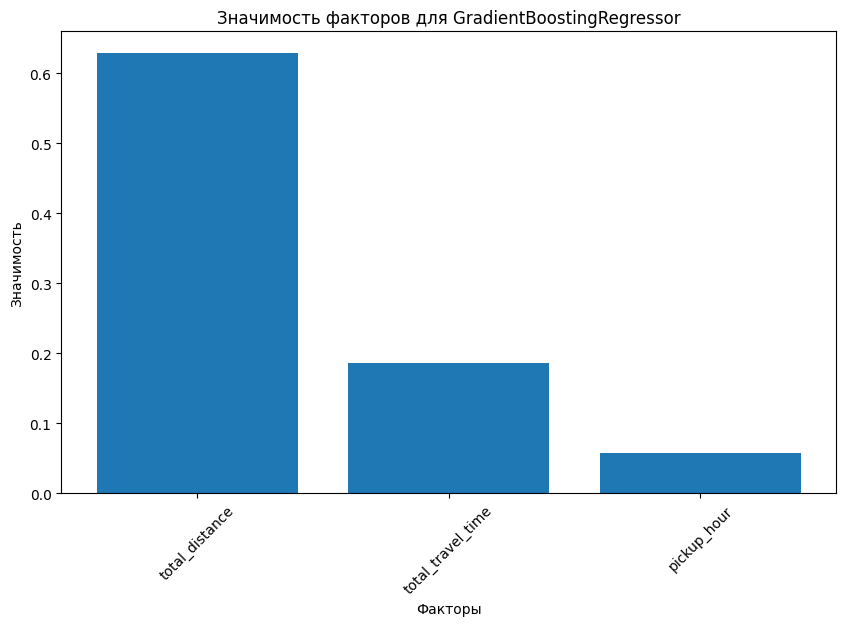

Топ-3 наиболее значимых факторов:
               Фактор  Значимость
9      total_distance    0.628181
10  total_travel_time    0.186373
7         pickup_hour    0.057439


In [ ]:
# Получите коэффициенты значимости факторов
feature_importances = GBR.feature_importances_

# Создайте DataFrame для удобства
feature_importance_df = pd.DataFrame({'Фактор': X_train[best_features].columns, 'Значимость': feature_importances})

# Отсортируйте по значимости в убывающем порядке
feature_importance_df = feature_importance_df.sort_values(by='Значимость', ascending=False)

# Выберите топ-3 наиболее значимых факторов
top_3_features = feature_importance_df.head(3)

# Постройте столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(top_3_features['Фактор'], top_3_features['Значимость'])
plt.xlabel('Факторы')
plt.ylabel('Значимость')
plt.title('Значимость факторов для GradientBoostingRegressor')
plt.xticks(rotation=45)
plt.show()

print("Топ-3 наиболее значимых факторов:")
print(top_3_features)

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
# Обратное логарифмирование целевой переменной на валидационной выборке
y_valid_true = np.exp(y_valid_log) - 1

# Обратное логарифмирование предсказаний на валидационной выборке
y_valid_pred = np.exp(y_valid_predict) - 1

# Вычисление медианной абсолютной ошибки (MeAE)
meae = metrics.median_absolute_error(y_valid_true, y_valid_pred)

print("Медианная абсолютная ошибка (MeAE) на валидационной выборке:", meae)

Медианная абсолютная ошибка (MeAE) на валидационной выборке: 109.83117162616873


In [ ]:
y_valid_true

452652      389.0
585387      184.0
1226235       8.0
145996      550.0
120104      405.0
            ...  
346404      364.0
40569      1309.0
1295514     579.0
877794     1104.0
1108352     664.0
Name: trip_duration_log, Length: 481217, dtype: float64

## Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/lectures/Проектная практика/test_data.csv")
osrm_data_test = pd.read_csv("/content/drive/MyDrive/lectures/Проектная практика/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [ ]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [ ]:
y_test_predict = GBR.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict) - 1

In [ ]:
y_test_predict

array([ 877.59616254,  516.82493924,  408.43598939, ..., 1668.59009784,
       1934.4695913 , 1204.56599994])

In [ ]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('/content/drive/MyDrive/lectures/Проектная практика/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
!pip install xgboost

После чего модуль можно импортировать:

In [ ]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaler, label=y_train_log, feature_names=best_features)
dvalid = xgb.DMatrix(X_valid_scaler, label=y_valid_log, feature_names=best_features)
dtest = xgb.DMatrix(X_test_scaled, feature_names=best_features)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [ ]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42222	valid-rmse:5.42195
[10]	train-rmse:1.93569	valid-rmse:1.93563
[20]	train-rmse:0.78551	valid-rmse:0.78635
[30]	train-rmse:0.47924	valid-rmse:0.48127
[40]	train-rmse:0.42057	valid-rmse:0.42325
[50]	train-rmse:0.40874	valid-rmse:0.41188
[60]	train-rmse:0.40423	valid-rmse:0.40773
[70]	train-rmse:0.40110	valid-rmse:0.40502
[80]	train-rmse:0.39888	valid-rmse:0.40310
[90]	train-rmse:0.39739	valid-rmse:0.40183
[100]	train-rmse:0.39571	valid-rmse:0.40040
[110]	train-rmse:0.39416	valid-rmse:0.39911
[120]	train-rmse:0.39324	valid-rmse:0.39856
[130]	train-rmse:0.39188	valid-rmse:0.39752
[140]	train-rmse:0.39080	valid-rmse:0.39677
[150]	train-rmse:0.38992	valid-rmse:0.39616
[160]	train-rmse:0.38925	valid-rmse:0.39570
[170]	train-rmse:0.38854	valid-rmse:0.39529
[180]	train-rmse:0.38793	valid-rmse:0.39500
[190]	train-rmse:0.38720	valid-rmse:0.39469
[200]	train-rmse:0.38608	valid-rmse:0.39387
[210]	train-rmse:0.38533	valid-rmse:0.39352
[220]	train-rmse:0.38464	valid-rmse:0.39326

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [ ]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39107


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

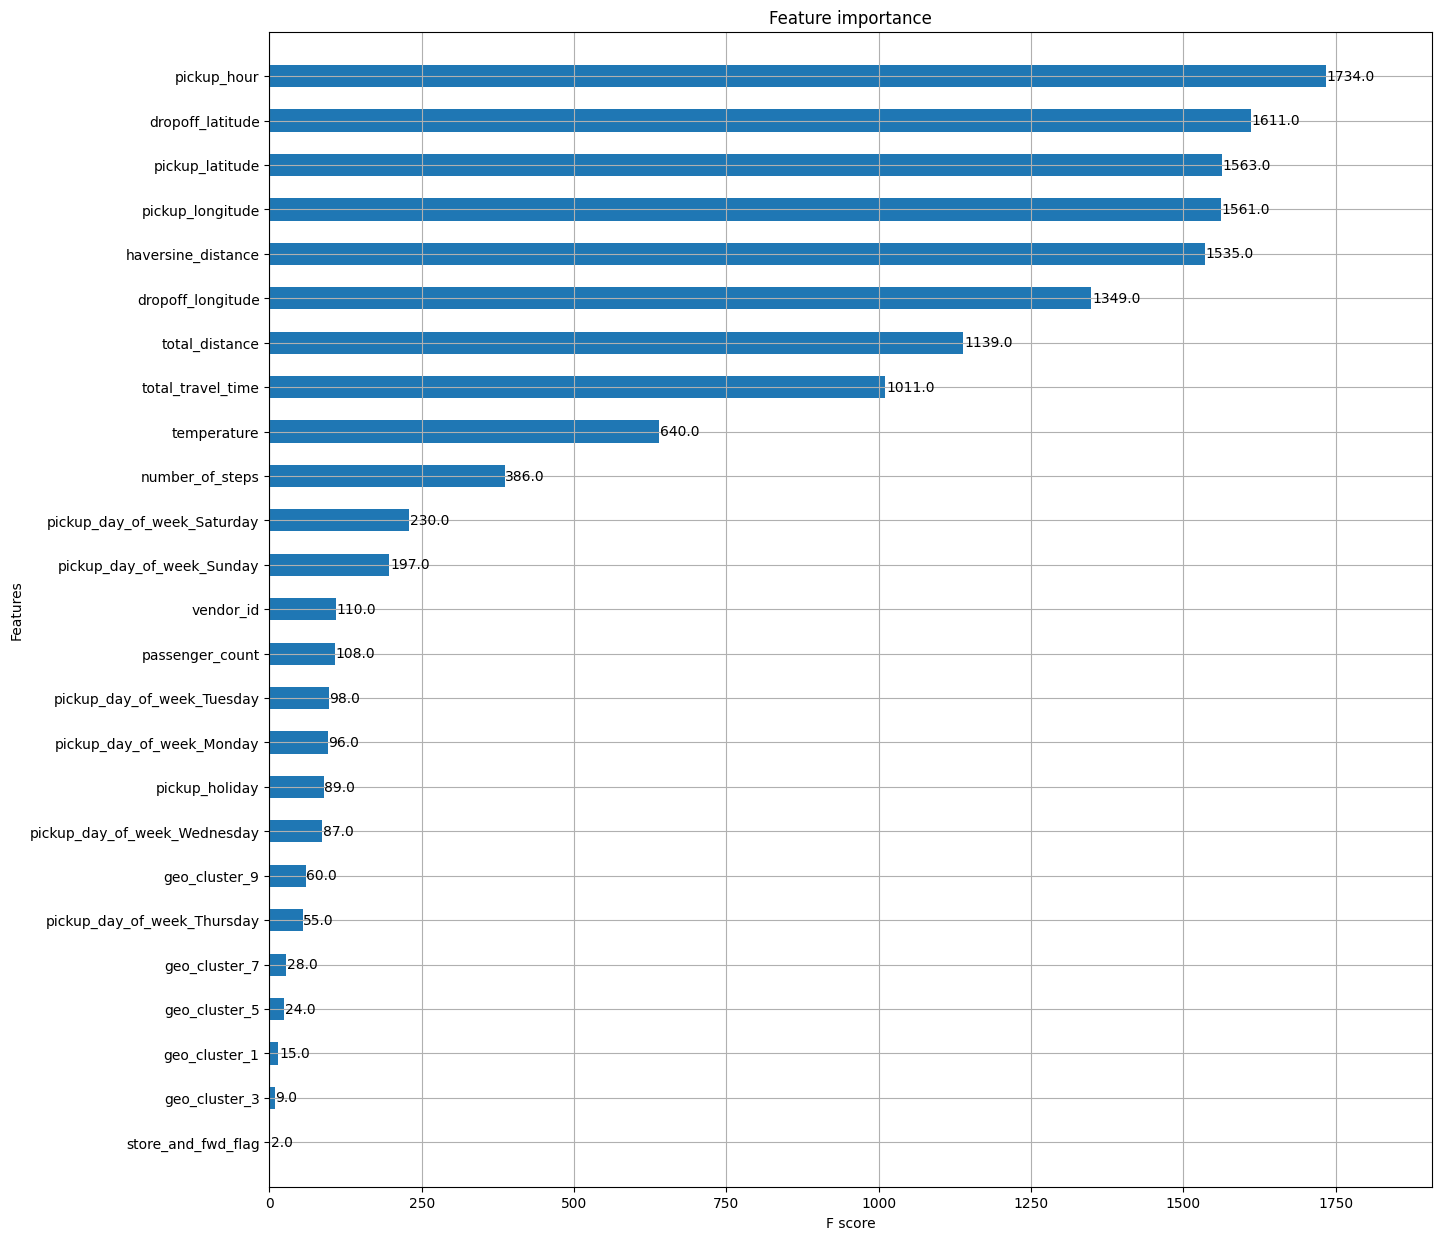

In [ ]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)